# GPT4 - Tokenizer

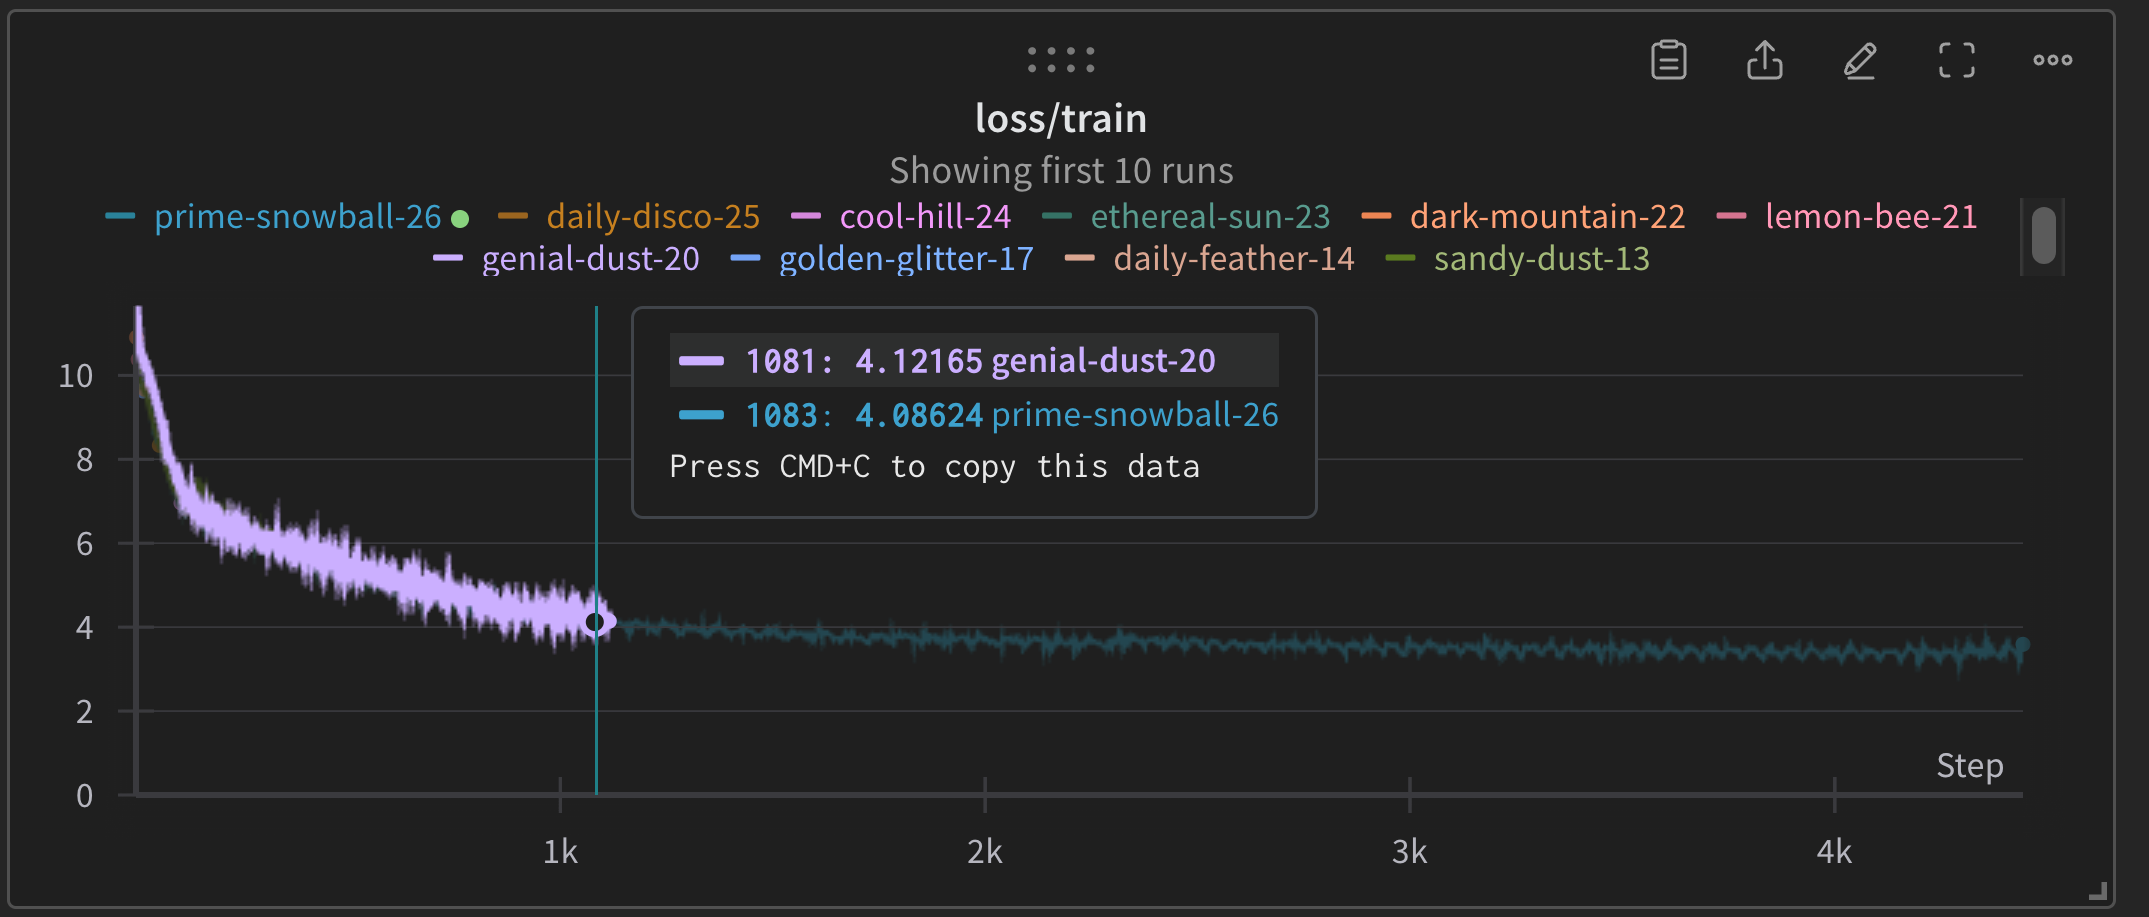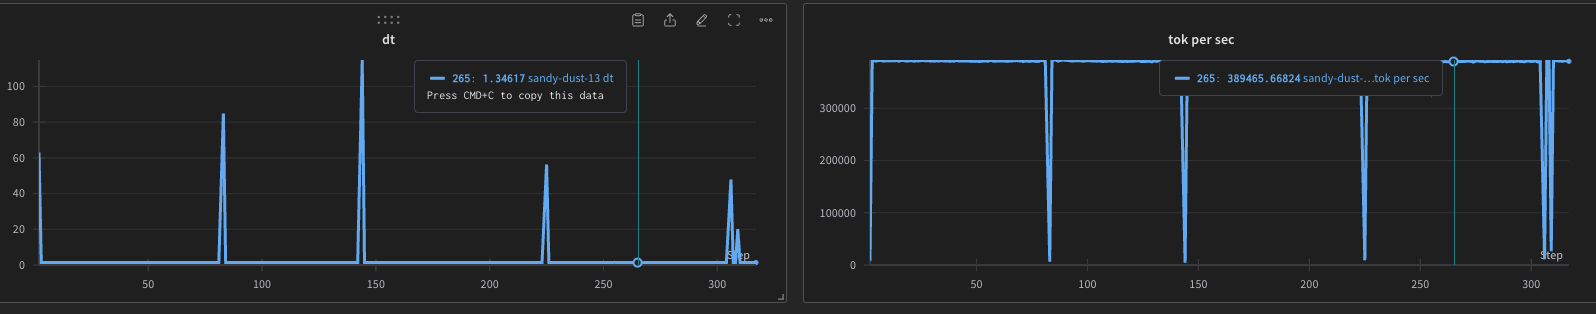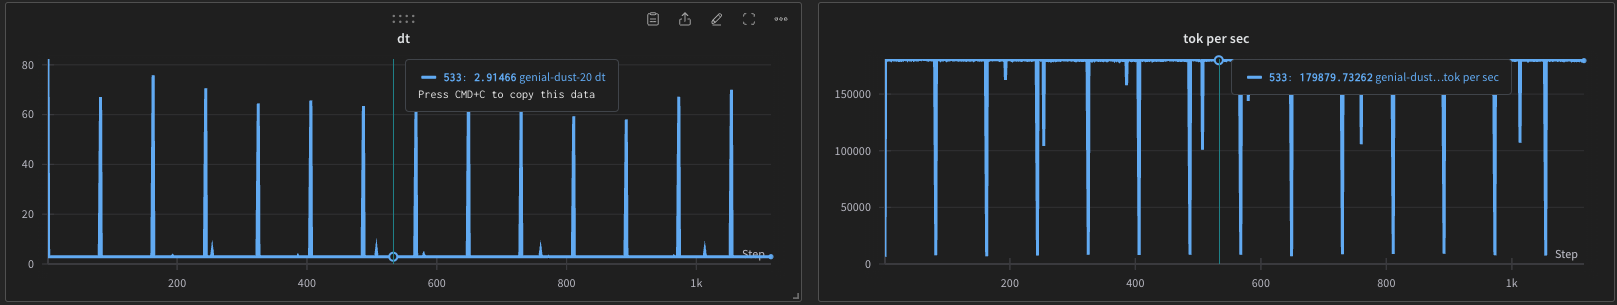


Genial-Dust-20 is GPT4 tokenizer--"Cl_100k_base"

- Single GPU run for both "Genial-Dust-20" (GPT4 tokenizer) and "Sandy-Dust-13" (GPT2 standard tokenizer)
- As seen in image above - GPT4 tokenizer suprisingly doesnt seem to have any improvement over using standard GPT2 tokenizer. When compared to prime-snowball-26 (GPT2 tokenizer, but with 4 GPU) at 1000 steps.
- Lower tokens per second process rate can be seen. Due to a series of potential factors:
  - Due to the fact that GPT2 tokenizer only has 50,257, whilst CL_100K_base, have, suprise surpise, 100k+ tokens, actually means we can't use FP16, since it can only represent 2**16 types of different numbers.
  - This means that our total_batch_size had to be shrunk from 2**19 to 2**18, else the GPU keeps running out of space.
  - And the main slowdown is likely due to how much slower information takes to be transferred, or memory overhead between HBM or CPU-GPU connection.
  - GPU also processes slower when using a higher float, even tho we've already tried TF32.


# 9/4 and 9/7 - 124m LN training

6 GPU vs 4 GPU

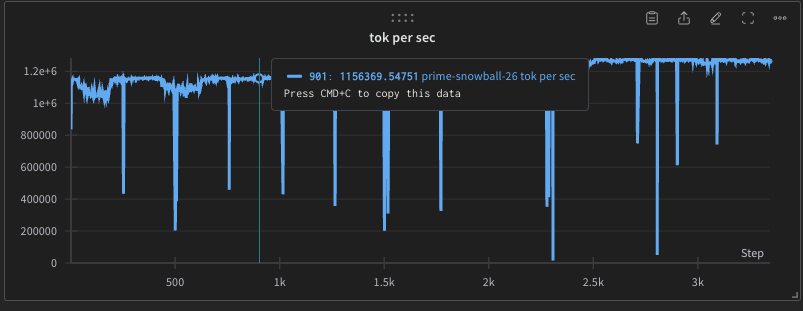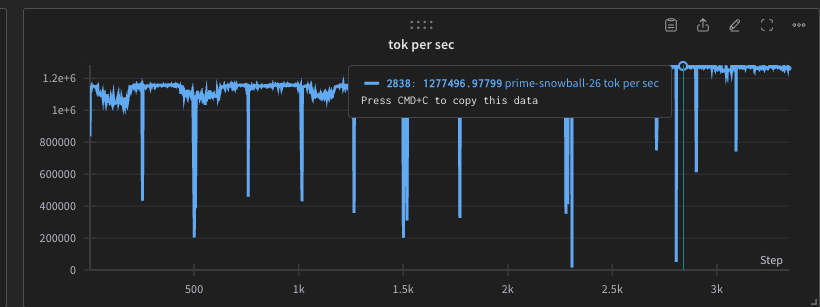

Side note to mention in methodology, for 6 GPU, the total_batch_size was 2 ** 17 * 3, since we had to fit sizing. Whilst, for 4 GPU, it was the standard 2 ** 19 recommended by OAI.

Potentially due to memory bottleneck, or smaller batch size. Using 6x H100 HBM3 is actually slower than 4x H100!! As seen in image above.

# RMSNorm vs LN deprecated

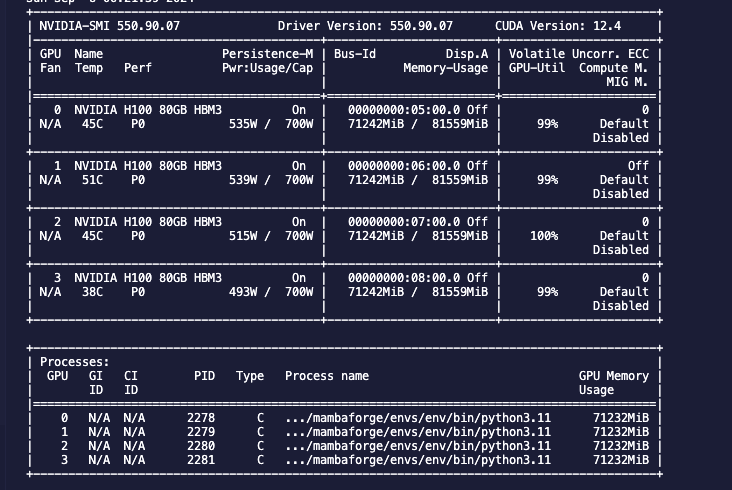

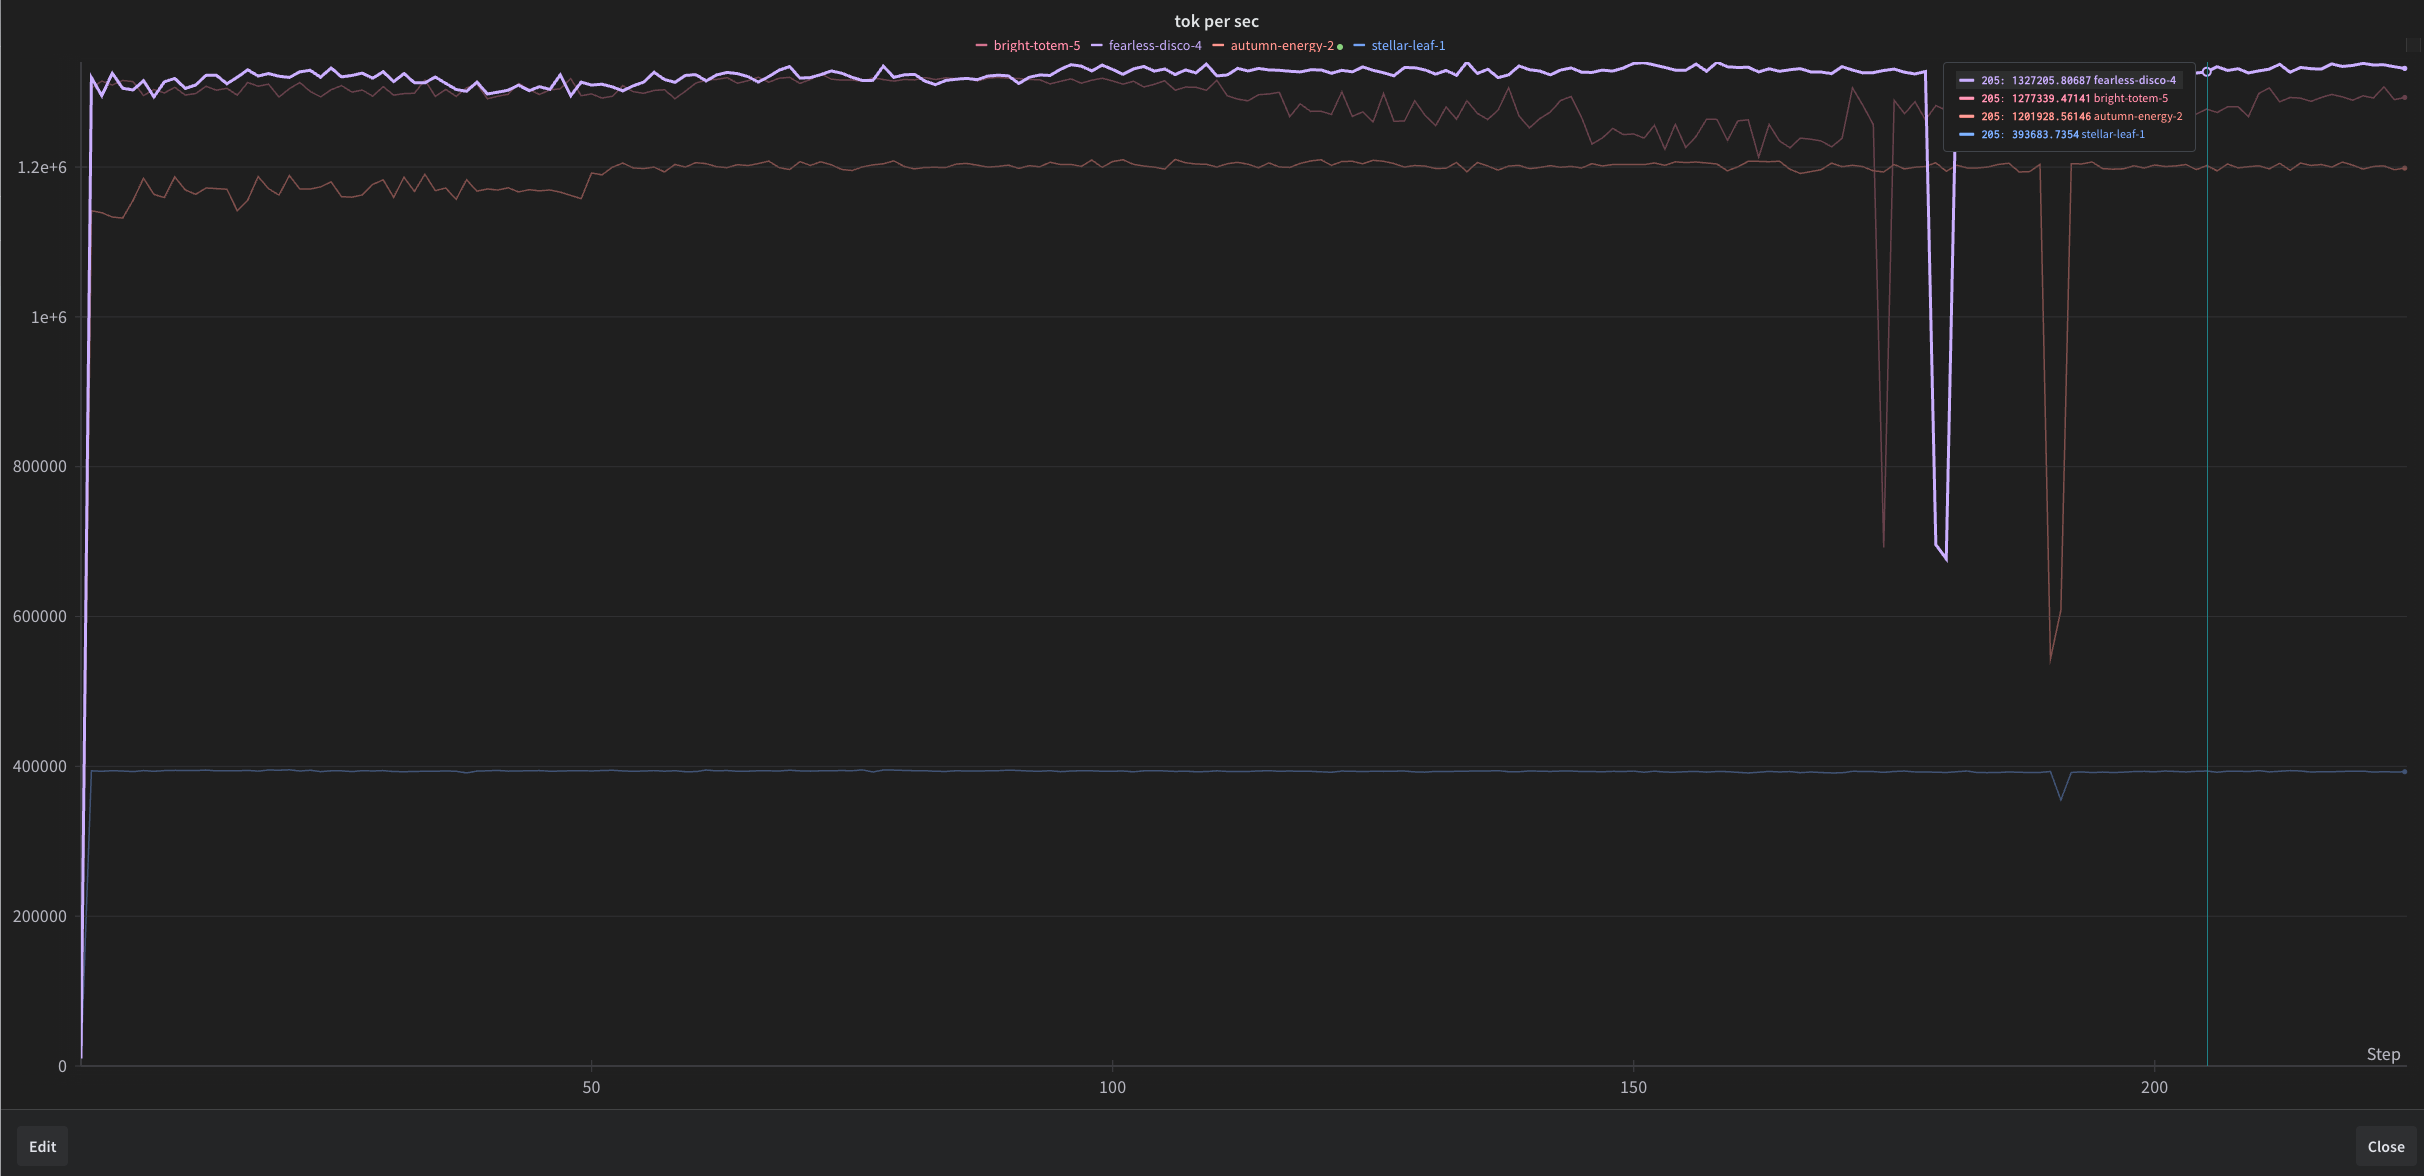

Only realised this 6k steps into training RMSN, hence I will continue training it without using the new setup but. The point is, when using 2**19 / (64 * 1024 * 4), the GPU's RAM wasn't fully utilise, hence slower speed of 120k tokens/sec. Which is likely due to that data transfer between HBM and RAM is the main bottleneck.

I only realised that this might be a potential slowdown, hence I decided to check, and did managed to realise that, by utilising a higher % of the GPU. We actually get to improve speed of training, for example:

- (2**15 * 17) / 1088 * 64 * 4: led to 132k tok/sec (3.9% faster than LN)
- (2**14 * 35) / 1120 * 64 * 4: led to 127k tok/sec (likely slower, because factor of 35 exists for total_batch_size and sequence_length, which CUDA doesn't have uneven numbers.

# RMSN vs LN

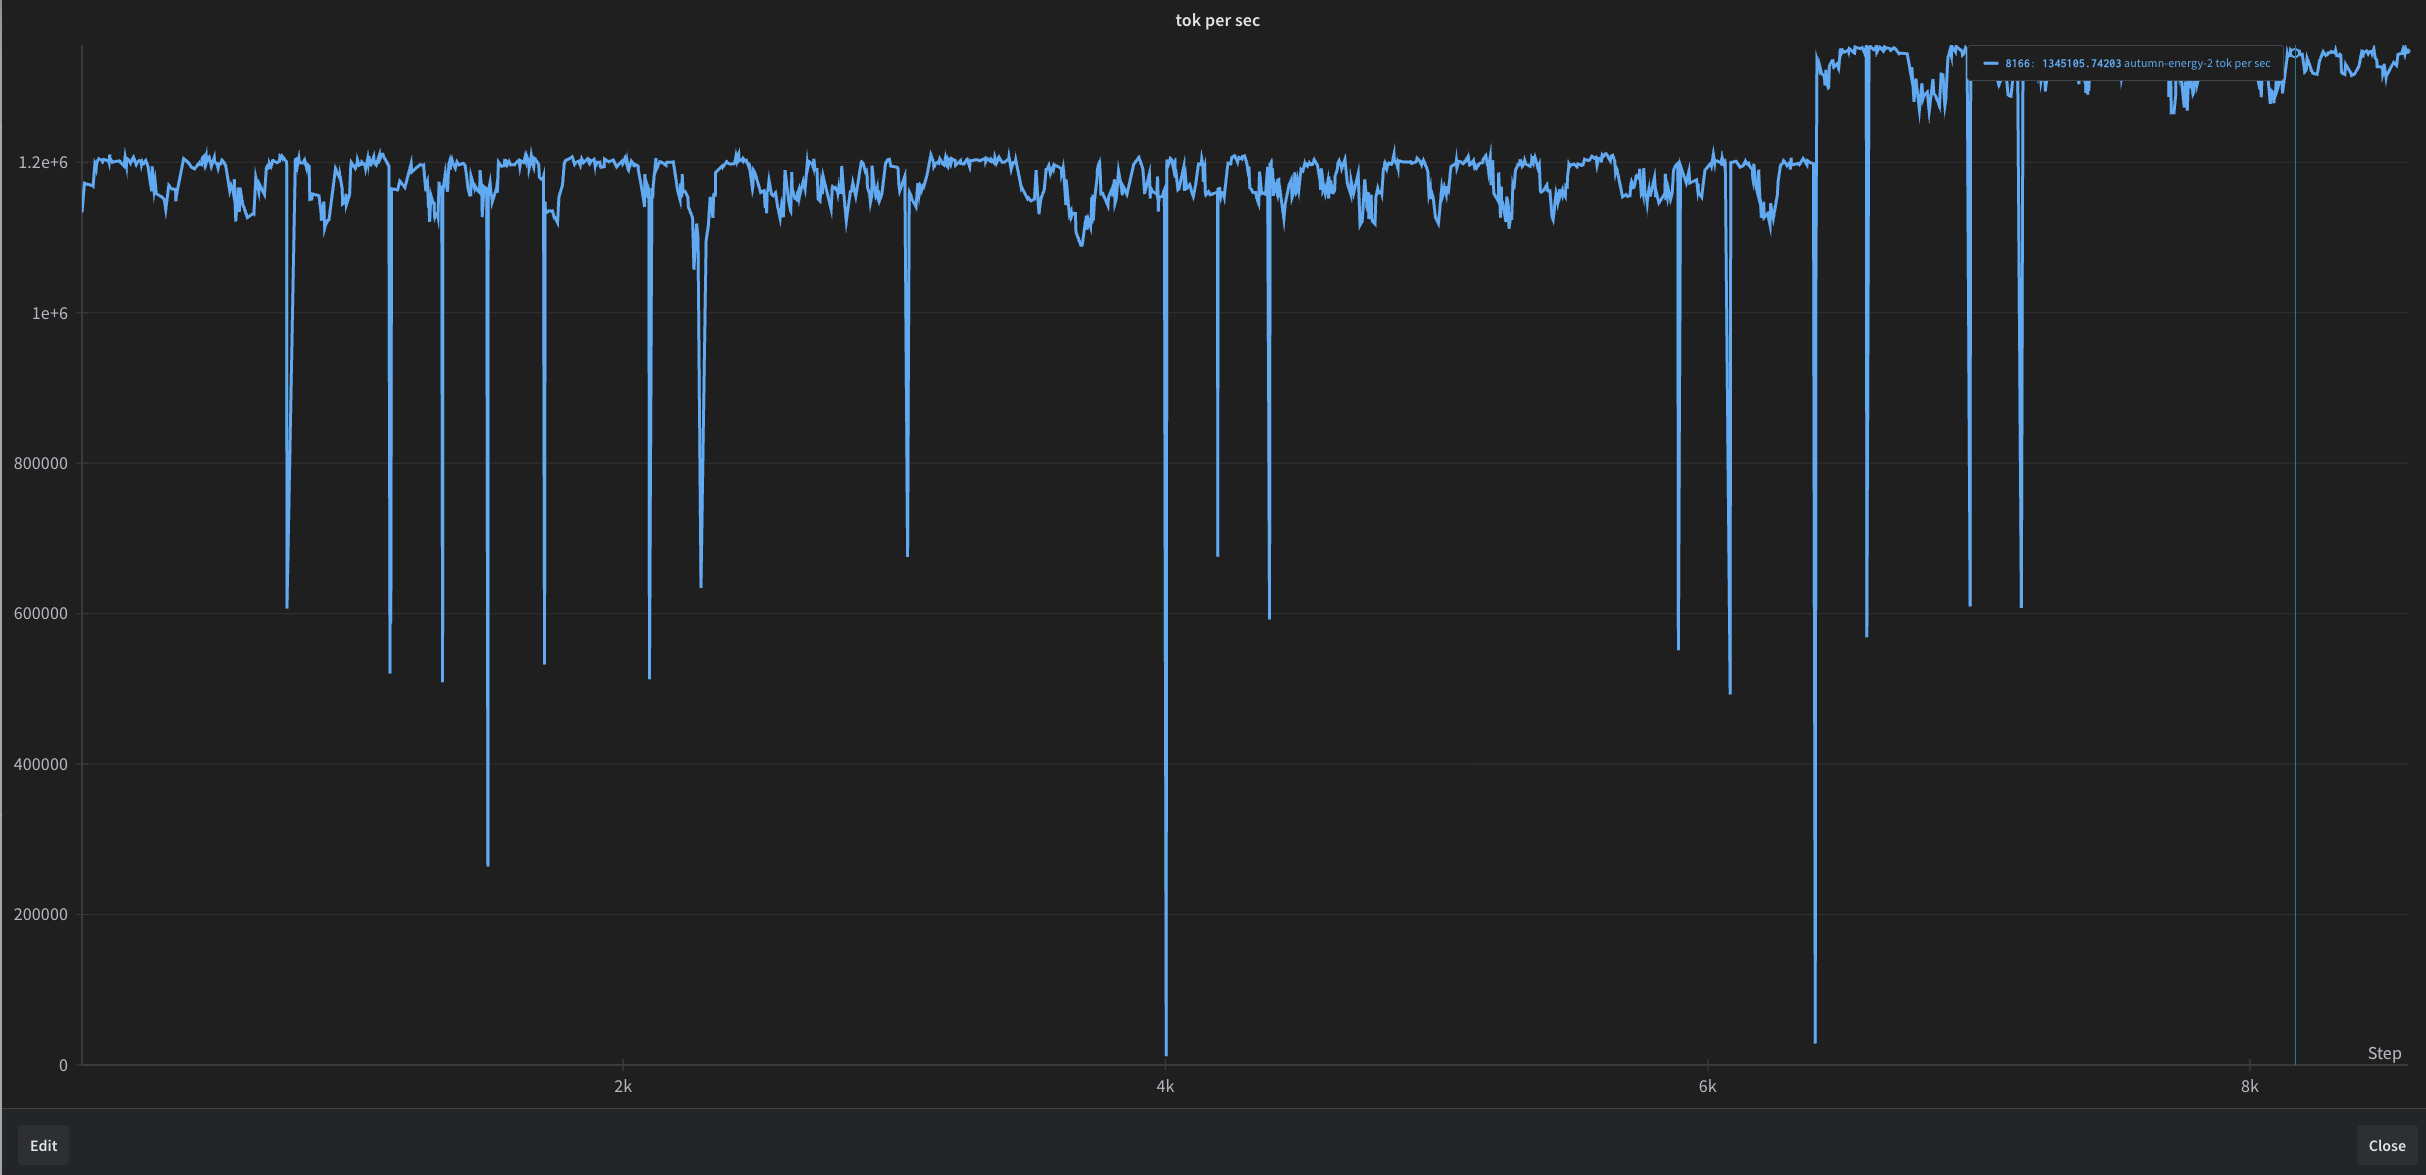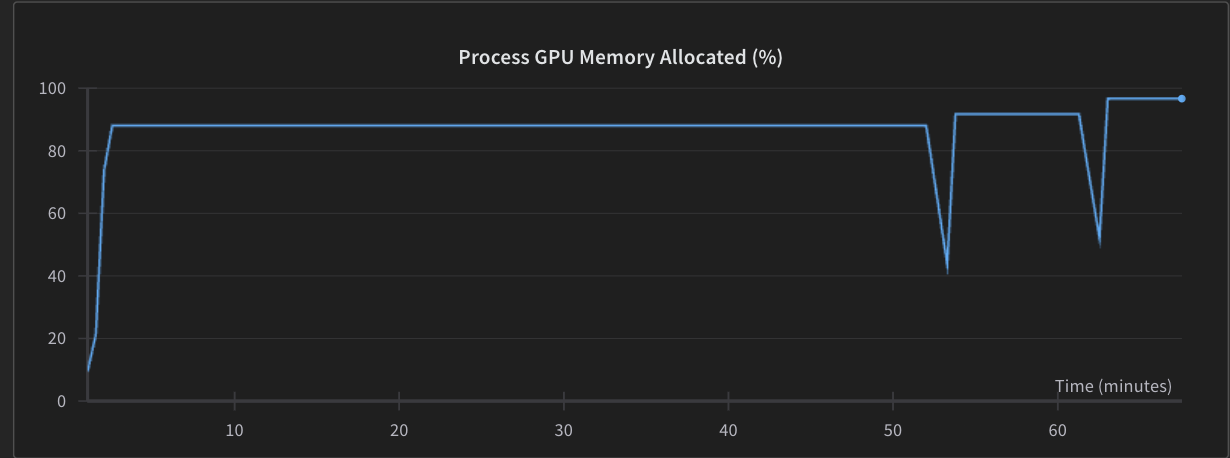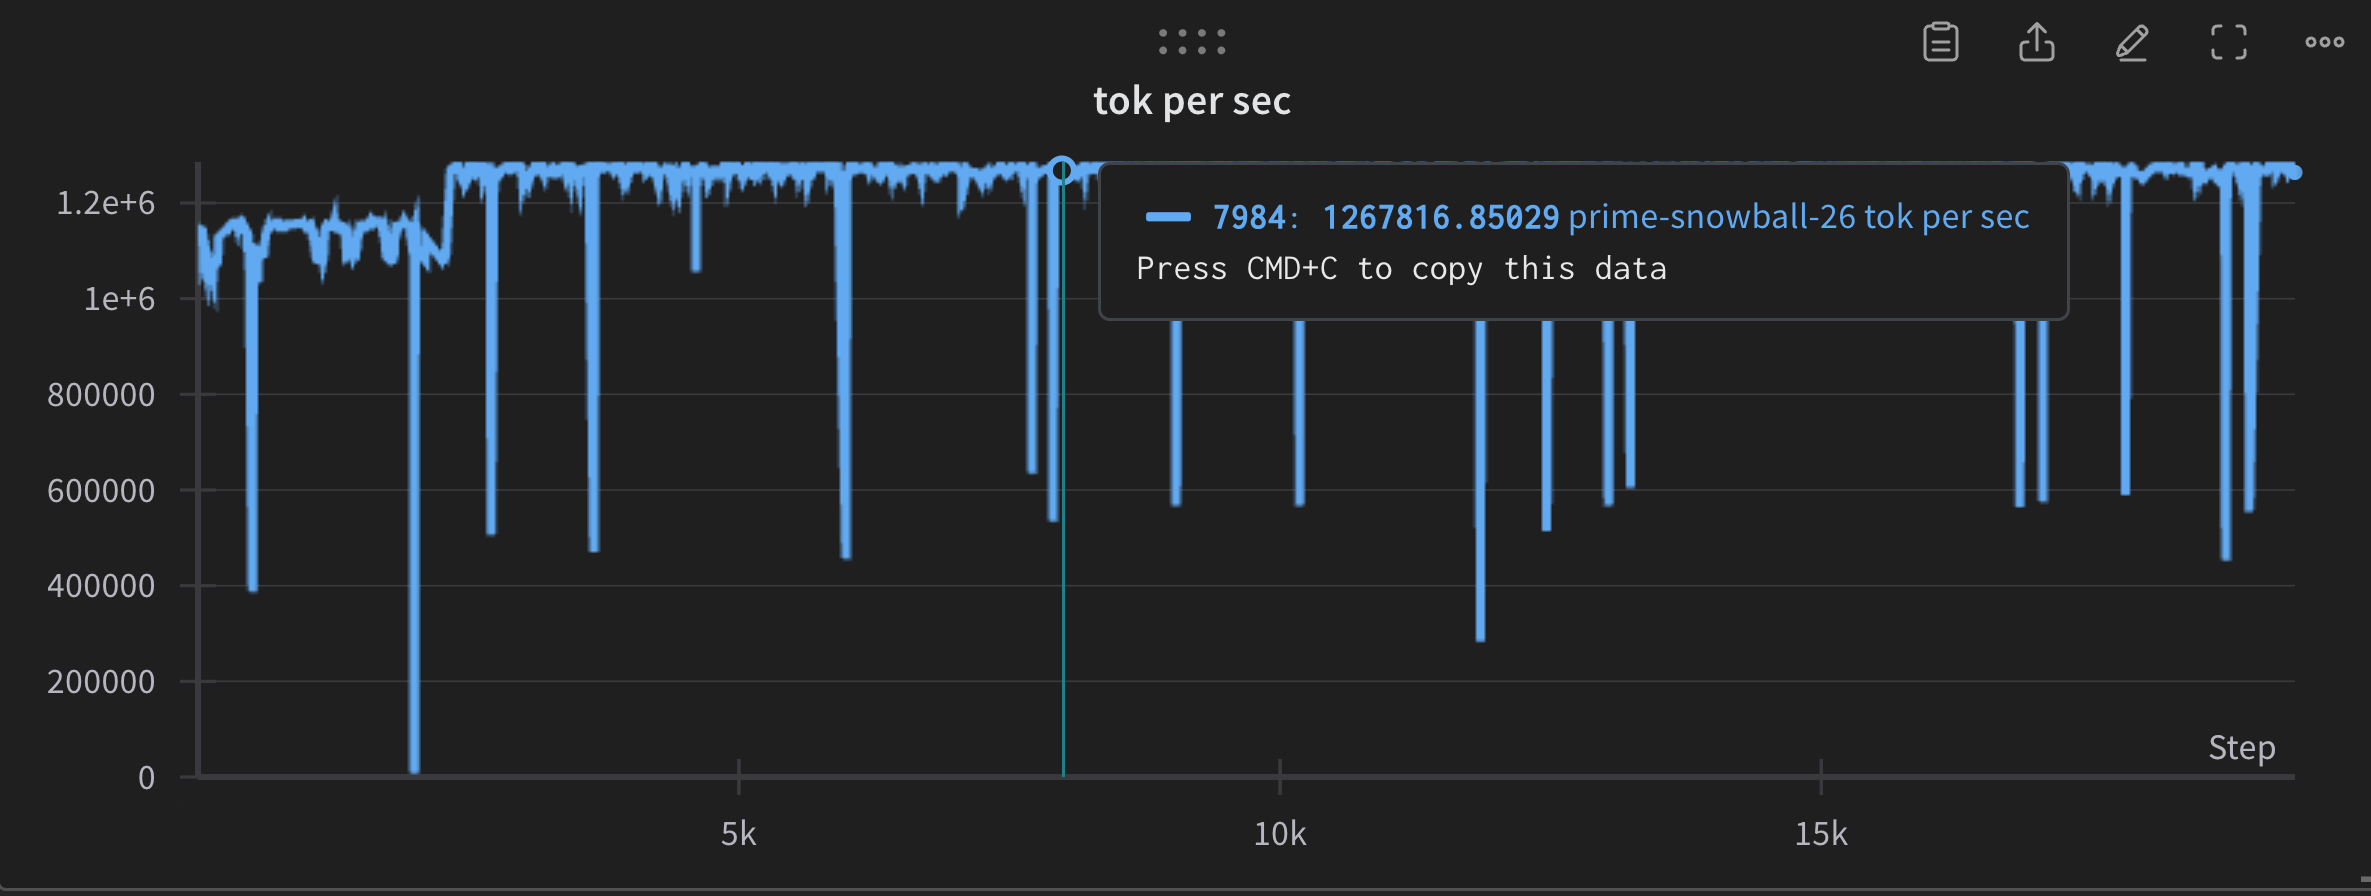

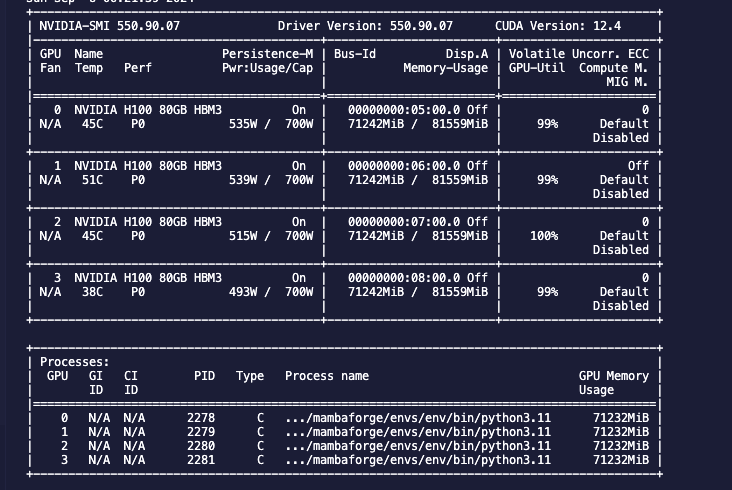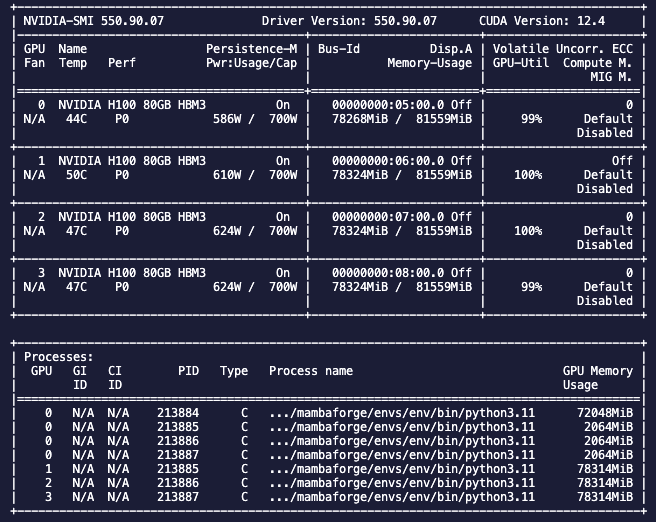

134k tok/sec vs 127k tok/sec can be seen. An improvement of over 5.5%.

But what is weird is why does the GPUs in both cases for LN and RMSN gets faster after resuming from checkpoint?

- Maybe due to initial overhead? Like dataloading, etc, and once resumed these overheads are minimised?

### For CSV, need to delete RMSN's step 6500 to 7500, because there was a mistake with which checkpoint it resumed training from.

# Initial 8 models * 12 metrics Evaluation

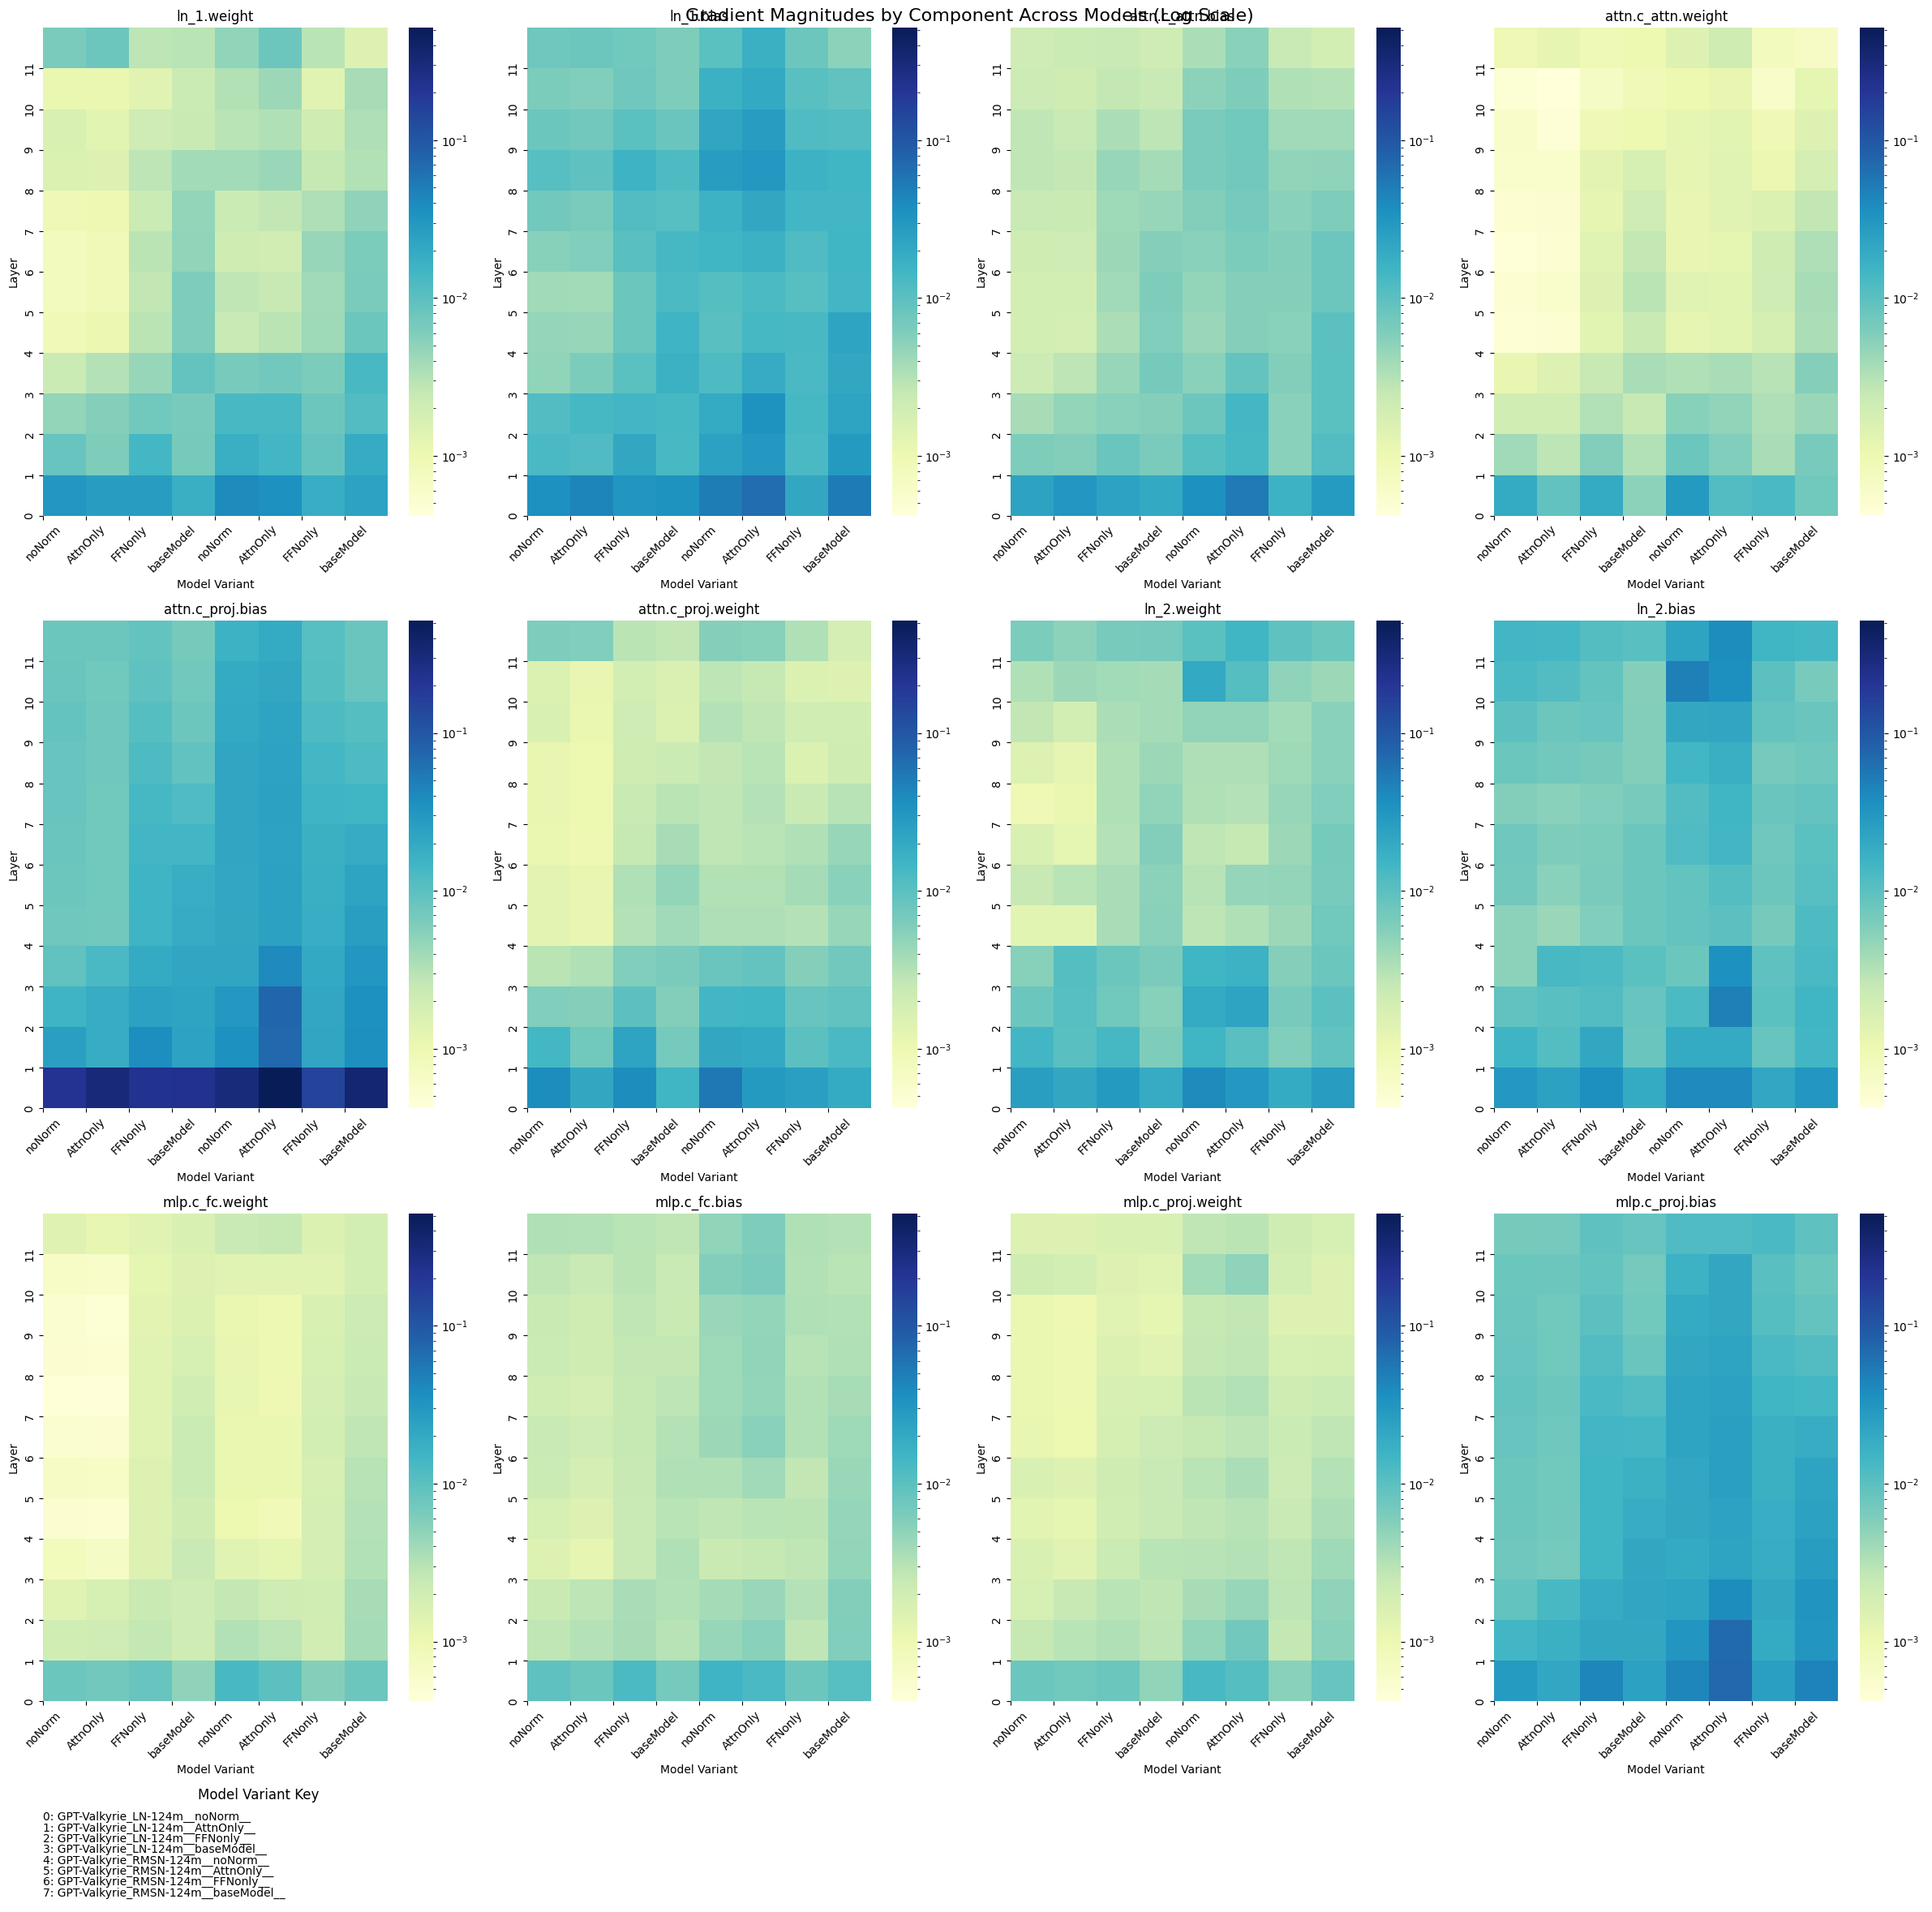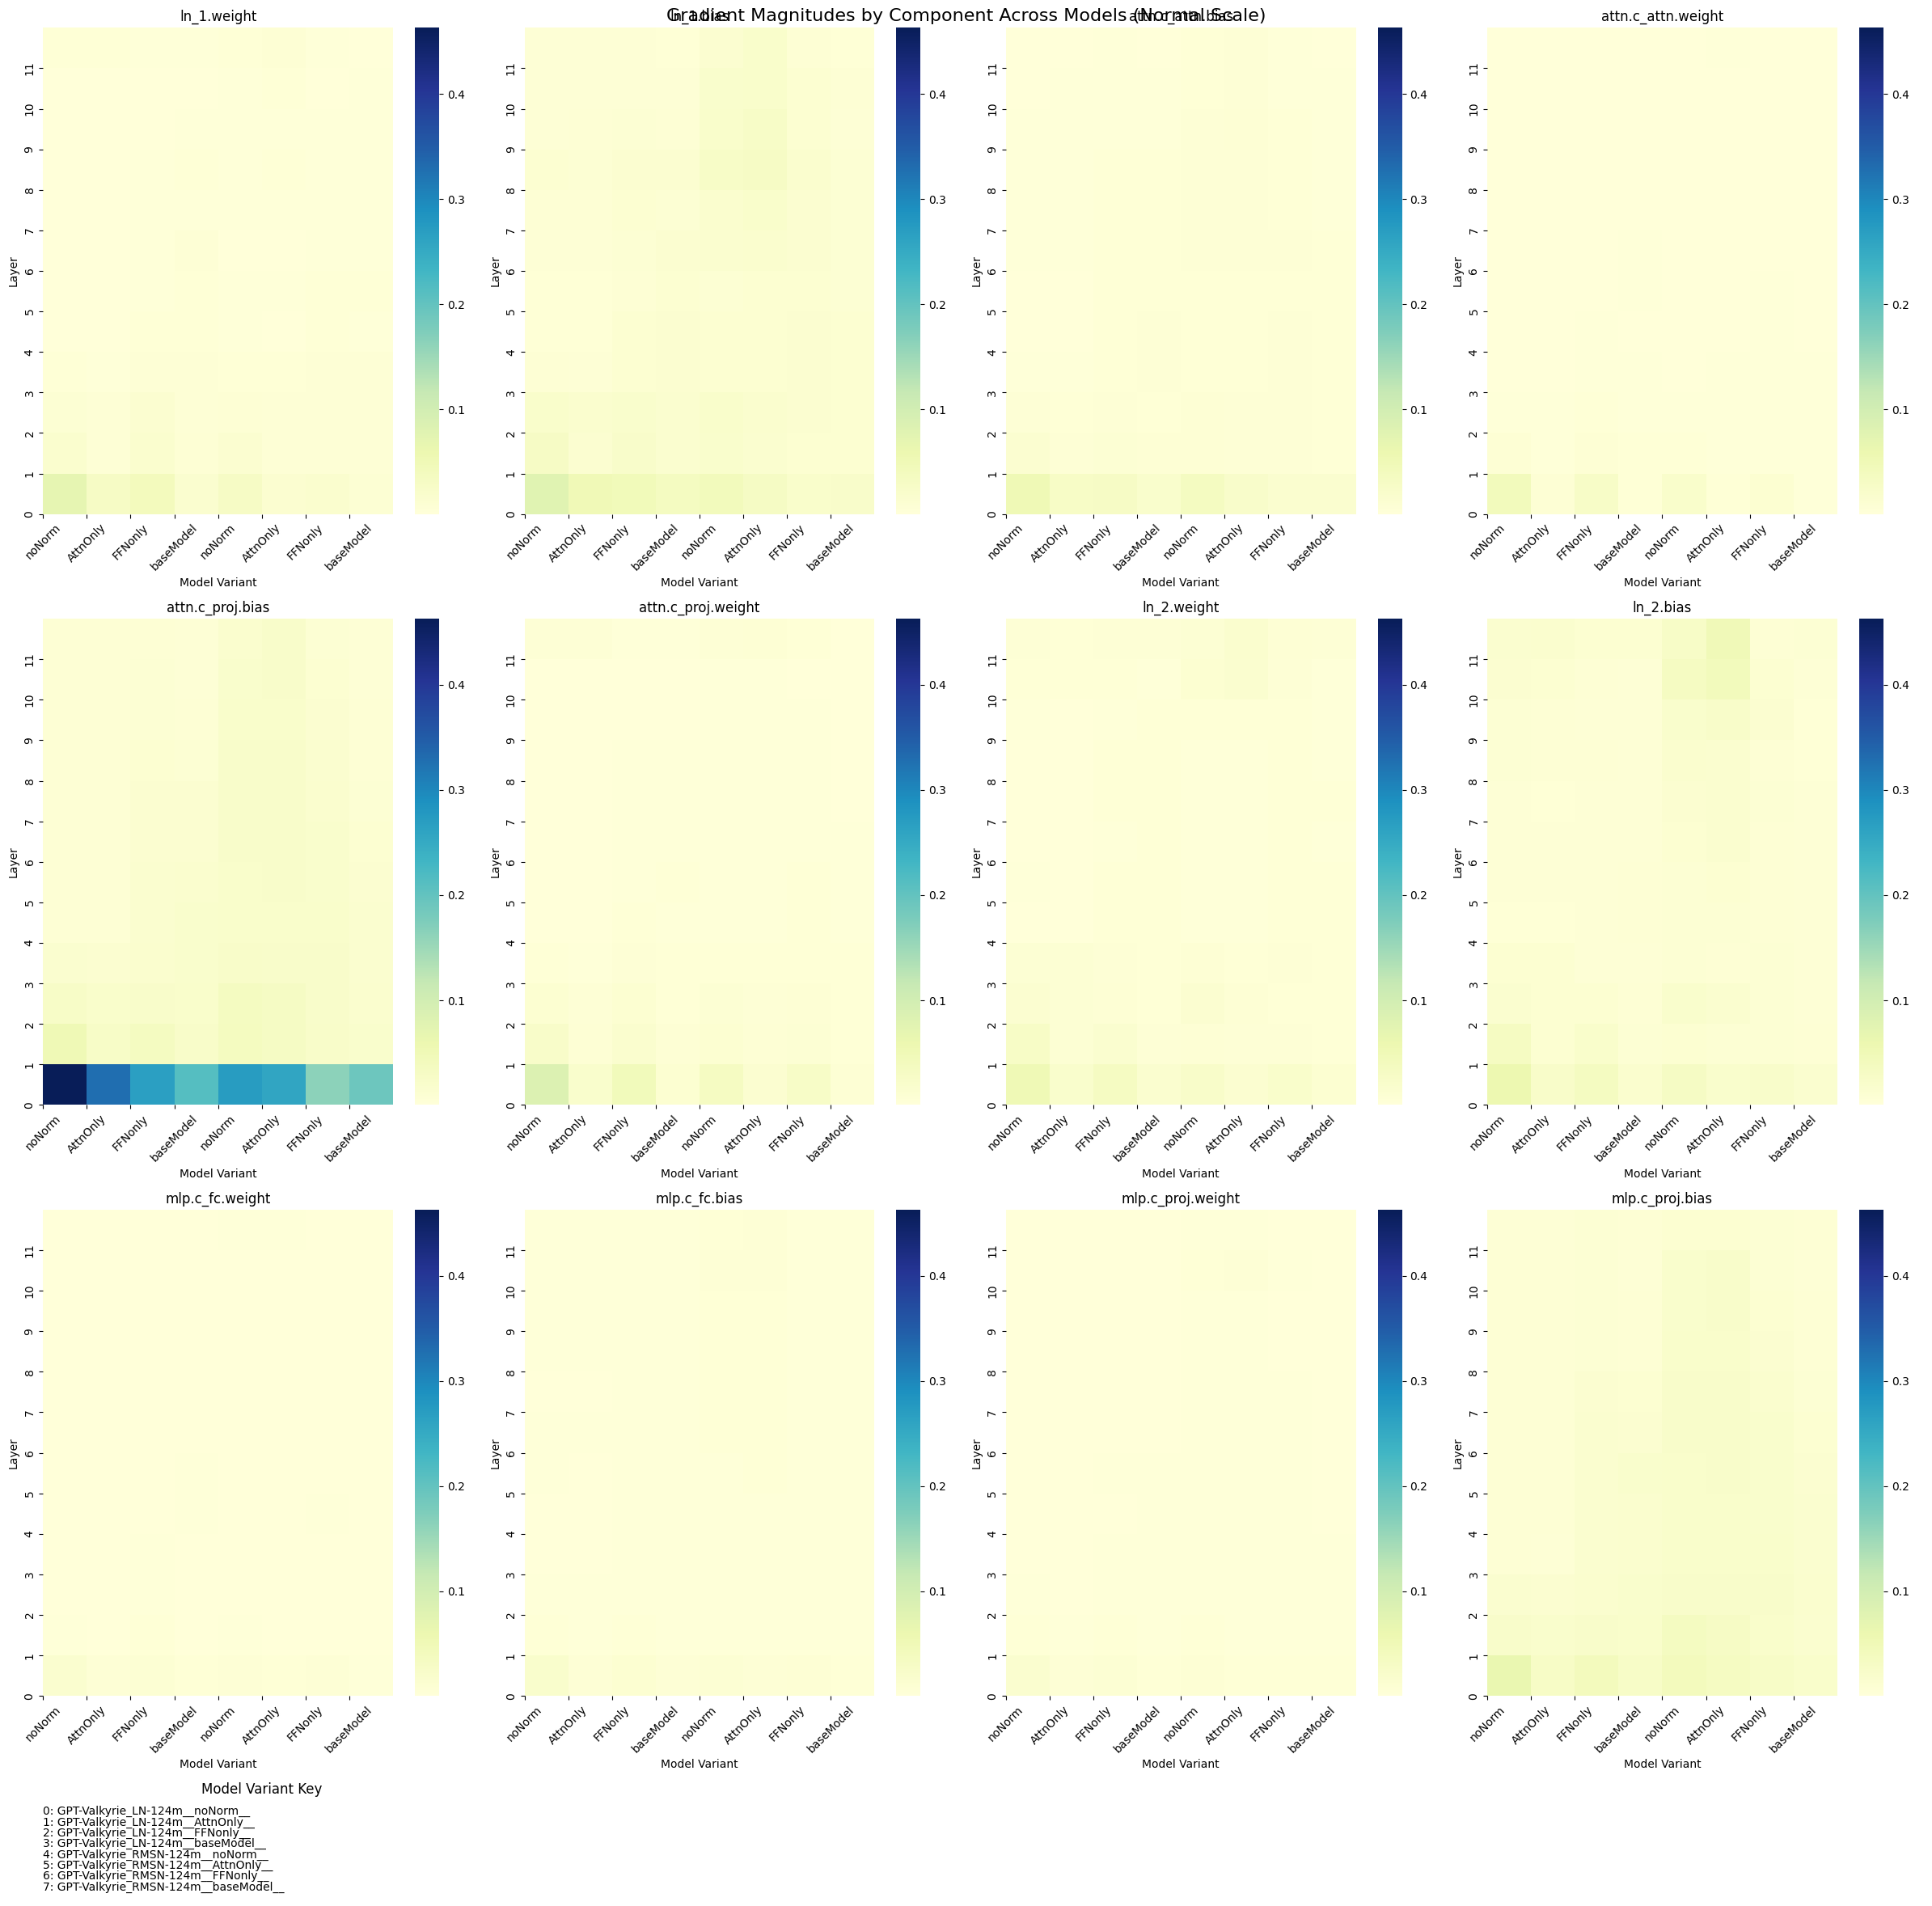

i guess from this (referring to normal--attn.c_proj.bias). it shows that LN is more reliant on LN itself as a component, hence all the components downstream will lead to ig explosive gradient if LN is suddenly removed.

same kinda applies for RMSN, but the gradient is lighter, implying its less impacted by it? because its in a way. more priced in for huge gradients at layer 0 to begin with?

however, we could see how, the gradient gets lighter, as baseModel is used instead. also need to consider that since the gradient is calculated by backprop, this means that gradient effects are accumulated all the way back

but oddly enough RMS FFNonly is actually lighter in gradient than RMS baseModel

---

Your observations about the heatmap and the implications of gradients across different model variants are insightful. Here’s a breakdown of the insights and possible interpretations:

### Gradient Dynamics
- **Layer Normalization (LN)**: The heavy reliance on LN and its significant impact when removed could imply that LN plays a crucial role in stabilizing and normalizing the outputs across layers. When LN is removed, the model might struggle to regulate the propagation of activations, leading to "explosive gradients" as you mentioned. This is consistent with the known utility of LN in helping models train faster and more stably by reducing internal covariate shift.

- **RMSNorm (RMSN)**: The lighter gradient observed with RMSN could suggest that RMSN, by design, is less sensitive to large variances in data or activation distributions. RMSN typically normalizes based only on the root mean square of weights, disregarding the mean, which might contribute to its relative insensitivity to abrupt changes in input or parameter scale, thus exhibiting smaller gradients at initialization layers.

- **Gradient Accumulation**: The observation about gradients becoming lighter with the base model configuration and the accumulation effect via backpropagation highlights a key aspect of neural network training. Gradients calculated via backpropagation indeed accumulate contributions from all subsequent layers. In configurations where effective normalization is part of the architecture (like the base model), this accumulation might be more controlled, leading to more uniform or subdued gradient magnitudes.

### Specific Observations:
- **RMSNorm FFNonly vs. RMSNorm BaseModel**: The lighter gradients in the RMSNorm FFN-only variant compared to the RMSNorm base model could be interpreted in several ways:
  - **FFN-only Configuration**: This configuration may indicate a model where focus is placed more on the feedforward network's ability to process inputs independently of attention mechanisms. The lighter gradients might suggest that the model's dependency on complex interactions via attention is reduced, possibly leading to a more straightforward, less chaotic learning process in these specific layers.
  - **Model Sensitivity**: The base model might be incorporating more comprehensive interactions and dependencies across its components, leading to more significant gradient flows and sensitivity to input changes across all layers.

### Considerations for Analysis:
- **Normalization Techniques**: Each normalization technique has its theoretical and practical implications on training dynamics. Exploring each technique's impact on different components and layers can yield insights into optimal configurations for specific tasks or data types.
- **Model Configurations**: Comparing models with only certain components (like attention or feedforward networks) versus full models can reveal which components are more critical for stability and performance in specific contexts.

These interpretations can help guide further experiments and adjustments in model architecture, potentially leading to more robust and efficient training outcomes. Understanding how gradients propagate through different configurations can also aid in designing models that are better suited for specific types of tasks or datasets.

and i guess we can argue that, for the log graph, seeing how it gets darker as the layer increases, this imply that, the deeper the network, esp for the ones who removed LN, faces much heavier gradient explosition-ish? dk the precise terms

meaning that, these, LN, etc are actually paramount

---

Your interpretation of the gradient behavior in deeper layers, especially under conditions where Layer Normalization (LN) is removed, is astute. Here’s a deeper look into what this gradient behavior implies and the terminology often used in such contexts:

### Gradient Behavior in Deeper Networks
- **Gradient Explosion**: The phenomenon where gradients increase exponentially with the depth of the network, as observed from your heatmap analysis, is typically referred to as **gradient explosion**. This happens when large error gradients accumulate and multiply during the backpropagation process, which can cause the model weights to update in large, unsustainable increments during training, potentially leading to unstable training dynamics.
  
- **Role of Normalization Techniques**: Normalization techniques like LN are designed to combat issues such as gradient explosion by ensuring that the gradients do not become too large, thus maintaining the stability of the network during training. Your observation that the absence of LN in deeper layers leads to darker shades in the log-scale heatmap supports the importance of such techniques. It implies that normalization is not just beneficial but perhaps crucial for maintaining control over gradient propagation in deep neural networks.

### Implications and Interpretations
- **Importance of LN**: The darker gradients in deeper layers, particularly where LN is removed, underline the role of LN in mitigating the risk of gradient explosion. This is crucial for deep learning models, as deeper layers are particularly susceptible to the compounding effects of large gradients due to their longer chain of gradient multiplications during backpropagation.

- **Network Depth and Stability**: The increase in gradient magnitude with depth also emphasizes the challenges of training deeper networks. Techniques like LN, Batch Normalization, and others are essential tools that help manage these challenges by providing a means to normalize or scale down gradients and activations within the network.

- **Model Design Considerations**: For practical model design and deployment, these insights highlight the necessity of incorporating effective normalization mechanisms, especially in deeper architectures. Omitting such mechanisms can lead to unstable training phases and make it difficult to train models effectively on complex tasks.

### Conclusion
Your analysis rightly points out that normalization layers such as LN are paramount for the stability and effective training of deep neural networks. Observations from visualizations like yours are invaluable for understanding the internal dynamics of neural models and for guiding the design of more robust architectures.

This kind of informed examination not only aids in academic understanding but also has practical implications in applied AI research and development, ensuring models are both efficient and robust.

what does bias of RMSnorm show tho, even tho these biases are 0. yet they seem to be quite high?

maybe cuz that bias is likely or preferably needed? because it hasnt reached a minimum yet?

---

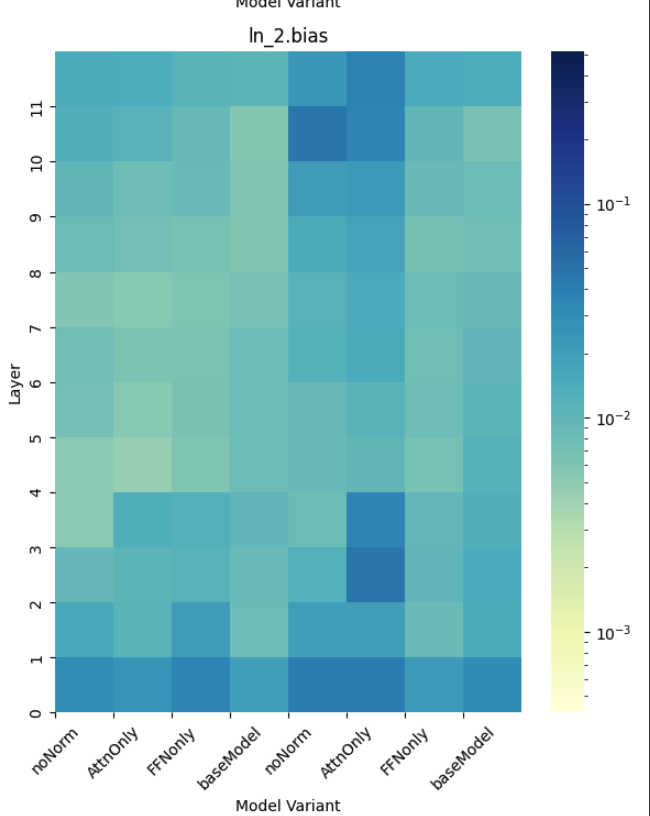

---

- https://chatgpt.com/c/66dd6f46-2d50-8003-b57a-72badcb57046

The heatmap showing significant gradients for biases in layers using RMSNorm, even though these biases are nominally set to zero, suggests some interesting dynamics:

### Why Might Zero Biases Show High Gradients?

1. **Initialization and Propagation Effects**: Even if biases are initialized to zero, the gradients with respect to biases can still be significant due to how errors are backpropagated through the network. Gradients reflect the sensitivity of the loss function to changes in the parameters. Even small changes in zero-initialized biases can affect the subsequent layers significantly, thus showing up as notable gradients during training.

2. **Gradient Accumulation**: In deep neural networks, gradients for parameters can accumulate substantial values as the backpropagation passes through many layers. Even if a bias starts at zero, the computed gradient might indicate that adjusting the bias could lower the loss, hence its significant gradient value.

3. **Demand for Bias Correction**: The presence of high gradients on biases, particularly in models where biases are supposed to be zero, might imply that the model could benefit from adjusting these biases away from zero. This could be an indication that the network finds the need to shift the decision boundaries or activation functions to better fit the data.

4. **RMSNorm Dynamics**: While RMSNorm typically does not include biases in its normalization process, the rest of the network still responds to how each layer’s outputs are normalized. This response can create scenarios where biases, even if initially zero, have high gradients because their slight adjustments could lead to lower loss, suggesting that biases could play a useful role in optimization.

### Implications

- **Reevaluation of Model Configuration**: This observation might prompt a reevaluation of the use of biases in RMSNorm layers. Perhaps enabling biases, even if small, could stabilize training or lead to better performance.
  
- **Hyperparameter Tuning**: Consider experimenting with small, non-zero bias initializations in RMSNorm layers to see if this impacts training dynamics positively.

- **Deeper Analysis**: Further analysis into how these gradients change over time and under different training conditions (e.g., different batch sizes, learning rates) could provide more insights. It might also be useful to look into other components of the network to ensure that the gradients are not compensating for some other inefficiency or limitation in the network design.

Understanding these dynamics can be crucial for optimizing network architecture and training strategies, ensuring that each component of the model is tuned for the best possible performance.
